In [1]:
%load_ext autoreload
%autoreload 2

# Pregunta 2

Análisis de vivienda de "data/raw/datos_viviendas_censo.csv"

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data_observatory_test_062025.config import INTERIM_DATA_DIR
from data_observatory_test_062025.load_data_viviendas import load_data_viviendas
from data_observatory_test_062025.generic_eda_report import generic_report

2025-06-06 00:34:41.159 | INFO     | data_observatory_test_062025.config:<module>:11 - PROJ_ROOT path is: /var/home/felipecabello/git/data_observatory_test_062025


In [3]:

# Cargamos las viviendas

df_viviendas = load_data_viviendas()

In [46]:
# eda generico para sacarlo de encima rápido, y tenerlo como referencia

generic_report(df_viviendas)

<class 'pandas.core.frame.DataFrame'>
Index: 31652 entries, 0 to 31651
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_vivienda            31652 non-null  object 
 1   comuna                 31652 non-null  object 
 2   tipo_vivienda          31652 non-null  object 
 3   num_dormitorios        31652 non-null  int64  
 4   num_banos              31652 non-null  int64  
 5   superficie_m2          31652 non-null  float64
 6   ano_construccion       31652 non-null  int64  
 7   material_paredes       31652 non-null  object 
 8   material_techo         31652 non-null  object 
 9   num_personas_hogar     31652 non-null  int64  
 10  num_hombres            31652 non-null  int64  
 11  num_mujeres            31652 non-null  int64  
 12  num_menores_18         31652 non-null  int64  
 13  num_adultos_18_64      31652 non-null  int64  
 14  num_adultos_65_plus    31652 non-null  int64  
 15  ingreso

Es un dataset bien regular, sin datos faltantes, aunque igual hay que revusar

No me parece bien empezar el análisis de coherencia sin antes estandarizar y deduplicar la información


## 2.1.2 Estandarización y deduplicación (35%)

Implementa soluciones para:

1. Estandarizar nombres de comunas (ej: “Providencia”, “providencia”, “PROVIDENCIA” → formato único)
2. Detectar y manejar registros duplicados de viviendas
3. Corregir inconsistencias menores en encoding de caracteres
4. Estandarizar formatos de tipos de vivienda y materiales de construcción
5. Normalizar representaciones de servicios básicos (Sí/No)



In [5]:
df_viviendas["comuna"].unique()

array(['Vallenar', 'Coyhaique', 'La Serena', 'Curicó', 'Los Ángeles',
       'Providencia', 'San Antonio', 'Ñuñoa', 'San Fernando', 'Arica',
       'San Bernardo', 'Alto Hospicio', 'Ovalle', 'Villarrica', 'Iquique',
       'Calama', 'Las Condes', 'Copiapó', 'Puerto Montt', 'Rancagua',
       'Valparaíso', 'Valdivia', 'Talca', 'Puente Alto', 'Santiago',
       'La Florida', 'Punta Arenas', 'Coquimbo', 'Castro', 'Maipú',
       'Viña del Mar', 'Chillán', 'Quilpué', 'Los Andes', 'Talcahuano',
       'Osorno', 'Villa Alemana', 'Quillota', 'Concepción', 'Temuco',
       'Antofagasta', 'concepcion', 'Provi', 'VALPARAÍSO', 'CONCEPCIÓN',
       'Valpo', 'Stgo', 'Putre', 'LAS CONDES', 'PROVIDENCIA',
       'providencia', 'las condes', 'Condes', 'SANTIAGO', 'santiago',
       'valparaiso', 'Conce'], dtype=object)

In [6]:
print(f"\nComunas únicas antes de la limpieza: {df_viviendas['comuna'].nunique()}")

# Estrategia: Normalizar texto (minúsculas, sin espacios) y luego aplicar un mapeo para abreviaturas.
comuna_map = {
    'provi': 'Providencia',
    'valpo': 'Valparaíso',
    'valparaiso': 'Valparaíso',
    'stgo': 'Santiago',
    'conce': 'Concepción',
    'condes': 'Las Condes',
    'concepcion': 'Concepción',
}

# Apply cleaning steps
df_viviendas['comuna_limpia'] = df_viviendas['comuna'].str.lower().str.strip()
df_viviendas['comuna_limpia'] = df_viviendas['comuna_limpia'].replace(comuna_map)
df_viviendas['comuna_limpia'] = df_viviendas['comuna_limpia'].str.capitalize()


Comunas únicas antes de la limpieza: 57


In [7]:
print("Comunas estandarizadas:", sorted(df_viviendas['comuna_limpia'].dropna().unique()))

Comunas estandarizadas: ['Alto hospicio', 'Antofagasta', 'Arica', 'Calama', 'Castro', 'Chillán', 'Concepción', 'Copiapó', 'Coquimbo', 'Coyhaique', 'Curicó', 'Iquique', 'La florida', 'La serena', 'Las condes', 'Los andes', 'Los ángeles', 'Maipú', 'Osorno', 'Ovalle', 'Providencia', 'Puente alto', 'Puerto montt', 'Punta arenas', 'Putre', 'Quillota', 'Quilpué', 'Rancagua', 'San antonio', 'San bernardo', 'San fernando', 'Santiago', 'Talca', 'Talcahuano', 'Temuco', 'Valdivia', 'Vallenar', 'Valparaíso', 'Villa alemana', 'Villarrica', 'Viña del mar', 'Ñuñoa']


In [8]:
df_viviendas["id_vivienda"].tail(10)

31650        VIV_031650
31651        VIV_031651
31652    VIV_000848_DUP
31653    VIV_031079_DUP
31654    VIV_021263_DUP
31655    VIV_027704_DUP
31656    VIV_027866_DUP
31657    VIV_029093_DUP
31658    VIV_027375_DUP
31659    VIV_001560_DUP
Name: id_vivienda, dtype: object

In [9]:
df_viviendas[df_viviendas["id_vivienda"].isin(["VIV_000848_DUP", "VIV_000848"])]


,id_vivienda,comuna,tipo_vivienda,num_dormitorios,num_banos,superficie_m2,ano_construccion,material_paredes,material_techo,num_personas_hogar,...,jefe_hogar_sexo,jefe_hogar_educacion,agua_potable,electricidad,gas_natural,internet,telefono_fijo,vehiculo_propio,tenencia_vivienda,comuna_limpia
848,VIV_000848,Coyhaique,Departamento,2,1,136.8,1959,Ladrillo,Zinc,6,...,M,Sin estudios,No,Sí,Sí,Sí,No,No,Arrendada,Coyhaique
31652,VIV_000848_DUP,Coyhaique,Departamento,2,1,136.8,1959,Ladrillo,Zinc,6,...,M,Sin estudios,No,Sí,Sí,Sí,No,No,Arrendada,Coyhaique


In [10]:
print(f"\nNúmero total de registros antes de eliminar duplicados: {len(df_viviendas)}")

# Estrategia: Identificar y eliminar registros cuyo 'id_vivienda' contiene '_DUP'.
# Esto asume que el registro original (sin _DUP) es la fuente de verdad.
is_duplicate = df_viviendas['id_vivienda'].str.contains('_DUP', na=False)
num_duplicados = is_duplicate.sum()

print(f"Número de registros marcados como duplicados ('_DUP'): {num_duplicados}")

# Eliminar los registros duplicados
df_viviendas = df_viviendas[~is_duplicate].copy()
print(f"Número de registros después de eliminar duplicados: {len(df_viviendas)}")


Número total de registros antes de eliminar duplicados: 31660
Número de registros marcados como duplicados ('_DUP'): 8
Número de registros después de eliminar duplicados: 31652


In [11]:
df_viviendas["id_vivienda"].tail(10)

31642    VIV_031642
31643    VIV_031643
31644    VIV_031644
31645    VIV_031645
31646    VIV_031646
31647    VIV_031647
31648    VIV_031648
31649    VIV_031649
31650    VIV_031650
31651    VIV_031651
Name: id_vivienda, dtype: object

In [12]:

# Calculate string lengths
series_lengths = df_viviendas['id_vivienda'].str.len()

# Basic statistics
print("Length Statistics:")
print(series_lengths.describe())
print(f"\nMin length: {series_lengths.min()}")
print(f"Max length: {series_lengths.max()}")
print(f"Mode length: {series_lengths.mode().iloc[0]}")

Length Statistics:
count    31652.0
mean        10.0
std          0.0
min         10.0
25%         10.0
50%         10.0
75%         10.0
max         10.0
Name: id_vivienda, dtype: float64

Min length: 10
Max length: 10
Mode length: 10


In [13]:
for col in ['agua_potable', 'electricidad', 'gas_natural', 'internet', 'telefono_fijo', 'vehiculo_propio']:
    display(df_viviendas[col].unique())


array(['No', 'Sí'], dtype=object)

array(['No', 'Sí'], dtype=object)

array(['Sí', 'No'], dtype=object)

array(['Sí', 'No'], dtype=object)

array(['Sí', 'No'], dtype=object)

array(['Sí', 'No'], dtype=object)

Aquí de vamos a pasar todo a booleano por preferencia personal. Ahora, me llama la atención que los servicios bpásicos están completamente limpios

In [14]:
boolean_columns = ['agua_potable', 'electricidad', 'gas_natural', 'internet', 'telefono_fijo', 'vehiculo_propio']
# Make them booleans
df_viviendas[boolean_columns] = df_viviendas[boolean_columns].applymap(lambda x: x == 'Sí')

/tmp/ipykernel_77018/3916677317.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_viviendas[boolean_columns] = df_viviendas[boolean_columns].applymap(lambda x: x == 'Sí')


In [15]:
for col in ['agua_potable', 'electricidad', 'gas_natural', 'internet', 'telefono_fijo', 'vehiculo_propio']:
    display(df_viviendas[col].unique())

array([False,  True])

array([False,  True])

array([ True, False])

array([ True, False])

array([ True, False])

array([ True, False])

In [16]:
print(f"\nComunas únicas antes de la limpieza: {df_viviendas['tipo_vivienda'].nunique()}")

# Estrategia: Normalizar texto (minúsculas, sin espacios) y luego aplicar un mapeo para abreviaturas.
vivienda_map = {
    "pareada": "Casa pareada",
    "departam.": "Departamento",
    "depto.": "Departamento",
    "dpto": "Departamento",
    "mediagua": "Media agua"

}

# Apply cleaning steps
df_viviendas['tipo_vivienda_limpia'] = df_viviendas['tipo_vivienda'].str.lower().str.strip()
df_viviendas['tipo_vivienda_limpia'] = df_viviendas['tipo_vivienda_limpia'].replace(vivienda_map)
df_viviendas['tipo_vivienda_limpia'] = df_viviendas['tipo_vivienda_limpia'].str.capitalize()


Comunas únicas antes de la limpieza: 11


In [17]:
print("Tipo de vivienda:", df_viviendas['tipo_vivienda_limpia'].unique())

Tipo de vivienda: ['Casa' 'Casa pareada' 'Departamento' 'Media agua']


In [18]:
print("\nMaterial de paredes antes:", df_viviendas['material_paredes'].unique())


Material de paredes antes: ['Ladrillo' 'Madera' 'Adobe' 'Hormigón' 'Wood' 'hormigon' 'Concrete'
 'ladrillo' 'HORMIGÓN' 'LADRILLO']


In [19]:
print(f"\nComunas únicas antes de la limpieza: {df_viviendas['material_paredes'].nunique()}")

# Estrategia: Normalizar texto (minúsculas, sin espacios) y luego aplicar un mapeo para abreviaturas.
material_map = {
    "wood": "Madera",
    "hormigon": "Hormigón",
    "concrete": "Hormigón",

}

# Apply cleaning steps
df_viviendas['material_paredes_limpia'] = df_viviendas['material_paredes'].str.lower().str.strip()
df_viviendas['material_paredes_limpia'] = df_viviendas['material_paredes_limpia'].replace(material_map)
df_viviendas['material_paredes_limpia'] = df_viviendas['material_paredes_limpia'].str.capitalize()


Comunas únicas antes de la limpieza: 10


In [20]:
print("\nMaterial de paredes antes:", df_viviendas['material_paredes_limpia'].unique())


Material de paredes antes: ['Ladrillo' 'Madera' 'Adobe' 'Hormigón']


In [21]:
df_viviendas['material_techo'].unique()

array(['Losa', 'Tejas', 'Paja', 'Zinc', 'tejas', 'ZINC', 'Chapa',
       'Eternit'], dtype=object)

In [22]:
print(f"únicas antes de la limpieza: {df_viviendas['material_techo'].nunique()}")

# Estrategia: Normalizar texto (minúsculas, sin espacios) y luego aplicar un mapeo para abreviaturas.
material_techo_map = {
}

# Apply cleaning steps
df_viviendas['material_techo_limpia'] = df_viviendas['material_techo'].str.lower().str.strip()
df_viviendas['material_techo_limpia'] = df_viviendas['material_techo_limpia'].replace(material_techo_map)
df_viviendas['material_techo_limpia'] = df_viviendas['material_techo_limpia'].str.capitalize()

únicas antes de la limpieza: 8


In [23]:
df_viviendas['material_techo_limpia'].unique()

array(['Losa', 'Tejas', 'Paja', 'Zinc', 'Chapa', 'Eternit'], dtype=object)

__A estas alturas ya deberíamos haber creado una función para hacer esta limpieza__

In [24]:
display(df_viviendas['jefe_hogar_sexo'].unique())
display(df_viviendas['jefe_hogar_educacion'].unique())

array(['M', 'F'], dtype=object)

array(['Sin estudios', 'Media', 'Universitaria', 'Técnica', 'Básica'],
      dtype=object)

In [ ]:
# Aquí hicimos el paso final, que es reemplazar todas las variables intervenidas con sus nombre originales
df_viviendas['comuna'] = df_viviendas['comuna_limpia']
df_viviendas = df_viviendas.drop(columns=['comuna_limpia'])
df_viviendas['tipo_vivienda'] = df_viviendas['tipo_vivienda_limpia']
df_viviendas = df_viviendas.drop(columns=['tipo_vivienda_limpia'])
df_viviendas['material_paredes'] = df_viviendas['material_paredes_limpia']
df_viviendas = df_viviendas.drop(columns=['material_paredes_limpia'])
df_viviendas['material_techo'] = df_viviendas['material_techo_limpia']
df_viviendas = df_viviendas.drop(columns=['material_techo_limpia'])



In [26]:
df_viviendas.columns

Index(['id_vivienda', 'comuna', 'tipo_vivienda', 'num_dormitorios',
       'num_banos', 'superficie_m2', 'ano_construccion', 'material_paredes',
       'material_techo', 'num_personas_hogar', 'num_hombres', 'num_mujeres',
       'num_menores_18', 'num_adultos_18_64', 'num_adultos_65_plus',
       'ingreso_mensual_hogar', 'jefe_hogar_edad', 'jefe_hogar_sexo',
       'jefe_hogar_educacion', 'agua_potable', 'electricidad', 'gas_natural',
       'internet', 'telefono_fijo', 'vehiculo_propio', 'tenencia_vivienda'],
      dtype='object')

## 2.1.1 Análisis de coherencia interna
Identifica y documenta inconsistencias en:

1. Relación entre número de personas y distribución por género (hombres + mujeres = total)
2. Sumas de grupos etarios vs número total de personas por hogar
3. Relación lógica entre número de personas y dormitorios disponibles
4. Coherencia entre servicios básicos (ej: internet sin electricidad)
5. Valores anómalos en ingresos y características de la vivienda
6. Tipos de vivienda y materiales de construcción coherentes

Para cada inconsistencia, calcula: - Número de registros afectados - Magnitud promedio de la discrepancia - Rango de valores problemáticos

In [27]:
print("\n--- 2.1.1. Análisis de Coherencia Interna ---")


--- 2.1.1. Análisis de Coherencia Interna ---


In [28]:

def detectar_inconsistencias(df, validaciones, verbose=True):
    """
    Función genérica para detectar inconsistencias en un DataFrame y crear flags automáticamente.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame a validar
    validaciones : dict
        Diccionario con las validaciones a realizar. Estructura:
        {
            'nombre_validacion': {
                'condicion': expresión booleana o función,
                'flag_name': 'nombre_del_flag' (opcional, se genera automáticamente)
            }
        }
        O simplemente:
        {
            'nombre_validacion': condicion
        }
    verbose : bool
        Si True, imprime información detallada sobre cada inconsistencia encontrada
    
    Retorna:
    --------
    pandas.DataFrame
        DataFrame original con las columnas de flags añadidas
    dict
        Resumen de inconsistencias encontradas
    """
    
    df_resultado = df.copy()
    resumen_inconsistencias = {}
    
    for nombre_validacion, config in validaciones.items():

        condicion = config
        flag_name = f'{nombre_validacion}_flag'
        
        # Si la condición es una función, aplicarla al DataFrame
        if callable(condicion):
            mask_inconsistencia = condicion(df_resultado)
        else:
            # Si es una expresión booleana (Series), usarla directamente
            mask_inconsistencia = condicion
        
        # Contar registros afectados
        num_inconsistencias = mask_inconsistencia.sum()
        
        # Solo crear el flag si hay inconsistencias
        if num_inconsistencias > 0:
            df_resultado[flag_name] = mask_inconsistencia
            
            # Guardar información en el resumen
            resumen_inconsistencias[nombre_validacion] = {
                'registros_afectados': num_inconsistencias,
                'porcentaje': (num_inconsistencias / len(df_resultado)) * 100,
                'flag_creado': flag_name
            }
            
            # Imprimir información si verbose=True
            if verbose:
                print(f"\n{nombre_validacion.upper()}:")
                print(f"Registros afectados: {num_inconsistencias} ({(num_inconsistencias/len(df_resultado)*100):.2f}%)")
                print(f"Flag creado: '{flag_name}'")
        else:
            if verbose:
                print(f"\n{nombre_validacion.upper()}:")
                print("✓ No se encontraron inconsistencias")
    
    return df_resultado, resumen_inconsistencias




In [29]:
df_viviendas['suma_etarios'] = df_viviendas['num_menores_18'] + df_viviendas['num_adultos_18_64'] + df_viviendas['num_adultos_65_plus']
df_viviendas['suma_genero'] = df_viviendas['num_hombres'] + df_viviendas['num_mujeres']


validaciones = {
    'internet_sin_electricidad': lambda df: (df['internet'] == "Sí") & (df['electricidad'] == "No"),
    'telefono_fijo_sin_electricidad': lambda df: (df['telefono_fijo'] == "Sí") & (df['electricidad'] == "No"),
    'Departamento_madera': lambda df: (df['material_paredes'] == "Madera") & (df['tipo_vivienda'] == "Departamento"),
    'MediaAgua_Hormigon': lambda df: (df['material_paredes'] == "Hormigón") & (df['tipo_vivienda'] == "Media agua"),
    'Departamento_techo_paja': lambda df: (df['material_techo'] == "Paja") & (df['tipo_vivienda'] == "Departamento"),
    'Casa_pareada_techo_paja': lambda df: (df['material_techo'] == "Paja") & (df['tipo_vivienda'] == "Casa pareada"),
    'edad_jefe_hogar_anomala': lambda df: (df['jefe_hogar_edad'] < 18) | (df['jefe_hogar_edad'] > 110),
    'ingreso_anomalo': lambda df: (df['ingreso_mensual_hogar'] < 0) | (df['ingreso_mensual_hogar'] > 20000000),
    'inconsistencia_etaria': lambda df: df['num_personas_hogar'] != df['suma_etarios'],
    
    'techo_rustico_paredes_premium': lambda df: (df['material_techo'].isin(['Paja']) & df['material_paredes'].isin(['Hormigón'])),    
    'media_agua_losa': lambda df: ((df['tipo_vivienda'] == 'Media agua') & (df['material_techo'] == 'Losa')),
    'losa_adobe': lambda df: ((df['material_techo'] == 'Losa') & (df['material_paredes'] == 'Adobe')),
    'inconsistencia_de_genero': lambda df: df['num_personas_hogar'] != df['suma_genero'],
    'hogar_sin_personas': lambda df: df['num_personas_hogar'] <= 0
}

In [30]:
df_viviendas_validado, resumen = detectar_inconsistencias(df_viviendas, validaciones)


INTERNET_SIN_ELECTRICIDAD:
✓ No se encontraron inconsistencias

TELEFONO_FIJO_SIN_ELECTRICIDAD:
✓ No se encontraron inconsistencias

DEPARTAMENTO_MADERA:
Registros afectados: 1941 (6.13%)
Flag creado: 'Departamento_madera_flag'

MEDIAAGUA_HORMIGON:
Registros afectados: 2060 (6.51%)
Flag creado: 'MediaAgua_Hormigon_flag'

DEPARTAMENTO_TECHO_PAJA:
Registros afectados: 1870 (5.91%)
Flag creado: 'Departamento_techo_paja_flag'

CASA_PAREADA_TECHO_PAJA:
Registros afectados: 1891 (5.97%)
Flag creado: 'Casa_pareada_techo_paja_flag'

EDAD_JEFE_HOGAR_ANOMALA:
✓ No se encontraron inconsistencias

INGRESO_ANOMALO:
✓ No se encontraron inconsistencias

INCONSISTENCIA_ETARIA:
✓ No se encontraron inconsistencias

TECHO_RUSTICO_PAREDES_PREMIUM:
Registros afectados: 1855 (5.86%)
Flag creado: 'techo_rustico_paredes_premium_flag'

MEDIA_AGUA_LOSA:
Registros afectados: 1869 (5.90%)
Flag creado: 'media_agua_losa_flag'

LOSA_ADOBE:
Registros afectados: 1912 (6.04%)
Flag creado: 'losa_adobe_flag'

INCONSISTE

## Bonus: sistema de scoring de calidad de datos que permita evaluar la confiabilidad de cada registro de vivienda

In [31]:
def calcular_score_inconsistencias(df, nombre_score='score_inconsistencias', 
                                  tipo_score='count'):
    """
    Calcula un score de inconsistencias basado en la cantidad de flags por fila.
    Automáticamente detecta y usa todas las columnas que terminan en '_flag'.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con las columnas de flags
    nombre_score : str
        Nombre de la columna donde se guardará el score
    tipo_score : str
        Tipo de score a calcular:
        - 'count': Cuenta simple de flags activos
        - 'percentage': Porcentaje de flags activos sobre el total de flags

    
    Retorna:
    --------
    pandas.DataFrame
        DataFrame original con la columna de score añadida
    dict
        Información sobre el score calculado
    """
    
    df_resultado = df.copy()
    
    # Detectar automáticamente todas las columnas que terminan en '_flag'
    columnas_flags = [col for col in df.columns if col.endswith('_flag')]
    
    # Verificar que existan columnas de flags
    if not columnas_flags:
        print("No se encontraron columnas que terminen en '_flag' en el DataFrame")
        return df_resultado, {}
    
    # Calcular el score según el tipo especificado
    if tipo_score == 'count':
        # Suma simple de flags (True = 1, False = 0)
        df_resultado[nombre_score] = df_resultado[columnas_flags].sum(axis=1)
        
    elif tipo_score == 'percentage':
        # Porcentaje de flags activos
        df_resultado[nombre_score] = (df_resultado[columnas_flags].sum(axis=1) / len(columnas_flags)) * 100

    
    else:
        print(f"Tipo de score no reconocido: {tipo_score}")
        return df_resultado, {}
    
    # Calcular estadísticas del score
    info_score = {
        'columna_score': nombre_score,
        'tipo_score': tipo_score,
        'columnas_flags_usadas': columnas_flags,
        'num_flags': len(columnas_flags),
        'score_min': df_resultado[nombre_score].min(),
        'score_max': df_resultado[nombre_score].max(),
        'score_promedio': df_resultado[nombre_score].mean(),
        'registros_sin_inconsistencias': (df_resultado[nombre_score] == 0).sum(),
        'registros_con_inconsistencias': (df_resultado[nombre_score] > 0).sum()
    }
    
    
    return df_resultado, info_score

In [32]:
df_vivienda_score, info_score = calcular_score_inconsistencias(df_viviendas_validado, tipo_score="percentage")

In [33]:
info_score

{'columna_score': 'score_inconsistencias',
 'tipo_score': 'percentage',
 'columnas_flags_usadas': ['Departamento_madera_flag',
  'MediaAgua_Hormigon_flag',
  'Departamento_techo_paja_flag',
  'Casa_pareada_techo_paja_flag',
  'techo_rustico_paredes_premium_flag',
  'media_agua_losa_flag',
  'losa_adobe_flag'],
 'num_flags': 7,
 'score_min': np.float64(0.0),
 'score_max': np.float64(28.57142857142857),
 'score_promedio': np.float64(6.047011247314546),
 'registros_sin_inconsistencias': np.int64(21027),
 'registros_con_inconsistencias': np.int64(10625)}


## 2.1.3 Cálculo de indicadores derivados (35%)

Usando los datos limpios, calcula:

1. Razón personas por dormitorio y valida contra rangos lógicos
2. Índice de masculinidad por hogar (hombres/mujeres * 100)
3. Porcentaje de población por grupo etario por hogar
4. Ingreso per cápita por hogar
5. Identificación de viviendas con características atípicas

Genera visualizaciones que muestren: - Distribución de personas por dormitorio - Relación entre ingresos del hogar y servicios básicos disponibles - Identificación de outliers en características de vivienda


In [34]:
df_indicadores = df_vivienda_score.copy()

9   num_personas_hogar     31660 non-null  int64  
 10  num_hombres            31660 non-null  int64  
 11  num_mujeres            31660 non-null  int64  
 12  num_menores_18         31660 non-null  int64  
 13  num_adultos_18_64      31660 non-null  int64  
 14  num_adultos_65_plus    31660 non-null  int64 

In [35]:
# A) Razón personas por dormitorio (Hacinamiento)
df_indicadores['personas_por_dormitorio'] = df_indicadores['num_personas_hogar'] / df_indicadores['num_dormitorios']
df_indicadores['personas_por_dormitorio'] = df_indicadores['personas_por_dormitorio'].replace([np.inf, -np.inf], np.nan) # Handle division by zero if any

# B) Índice de masculinidad
df_indicadores['indice_masculinidad'] = (df_indicadores['num_hombres'] / df_indicadores['num_mujeres']) * 100
df_indicadores['indice_masculinidad'] = df_indicadores['indice_masculinidad'].replace([np.inf, -np.inf], np.nan)


# C) Porcentaje de población por grupo etario por hogar
df_indicadores["porc_menores_18"] = df_indicadores["num_menores_18"] / df_indicadores["num_personas_hogar"] * 100
df_indicadores["porc_adultos_18_64"] = df_indicadores["num_adultos_18_64"] / df_indicadores["num_personas_hogar"] * 100
df_indicadores["porc_adultos_65_plus"] = df_indicadores["num_adultos_65_plus"] / df_indicadores["num_personas_hogar"] * 100

# D) Ingreso per cápita
df_indicadores['ingreso_per_capita'] = df_indicadores['ingreso_mensual_hogar'] / df_indicadores['num_personas_hogar']
df_indicadores['ingreso_per_capita'] = df_indicadores['ingreso_per_capita'].replace([np.inf, -np.inf], np.nan)

# E) Viviendas atípicas
# Ya identificado con score_inconsistencias
# df_indicadores["score_inconsistencias"]


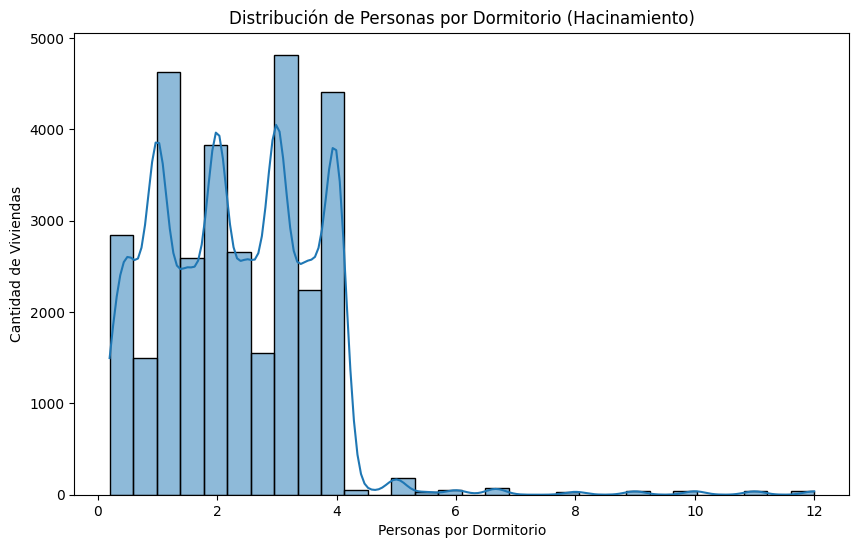

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(df_indicadores['personas_por_dormitorio'].dropna(), bins=30, kde=True)
plt.title('Distribución de Personas por Dormitorio (Hacinamiento)')
plt.xlabel('Personas por Dormitorio')
plt.ylabel('Cantidad de Viviendas')

plt.show()

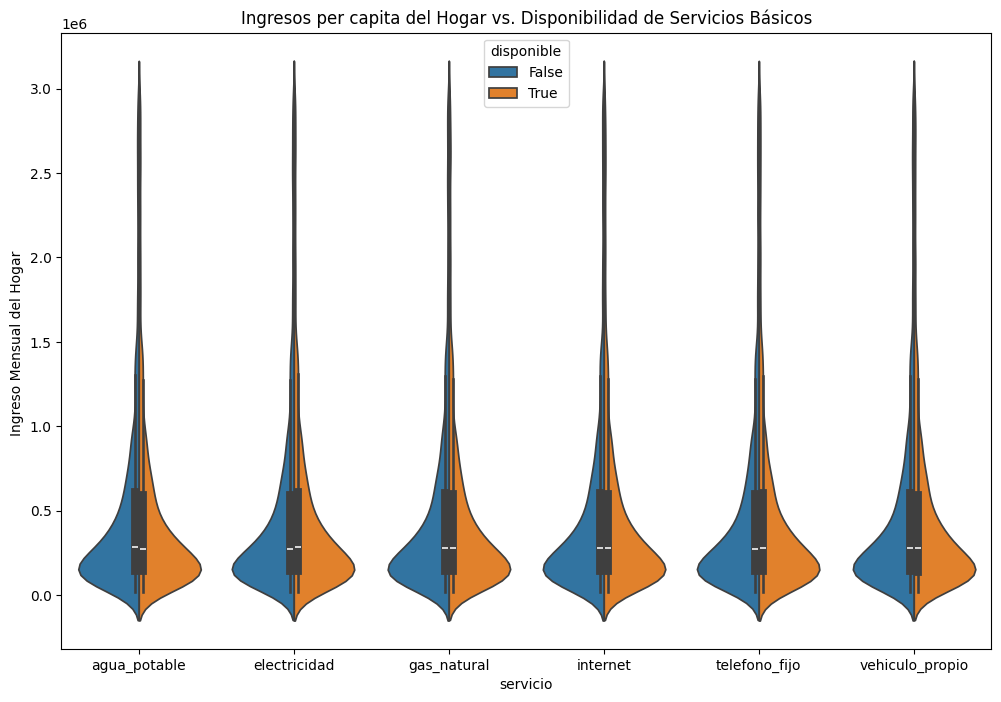

In [37]:
# B) Relación entre ingresos y servicios básicos
df_servicios = df_indicadores.melt(id_vars=['ingreso_per_capita'],
                              value_vars=['agua_potable', 'electricidad', 'gas_natural', 'internet', 'telefono_fijo', 'vehiculo_propio'],
                              var_name='servicio', value_name='disponible')

plt.figure(figsize=(12, 8))
sns.violinplot(data=df_servicios, x='servicio', y='ingreso_per_capita', hue='disponible',split=True)
plt.title('Ingresos per capita del Hogar vs. Disponibilidad de Servicios Básicos')
plt.ylabel('Ingreso Mensual del Hogar ')

plt.show()

In [38]:
df_servicios

,ingreso_per_capita,servicio,disponible
0,2.474753e+06,agua_potable,False
1,3.398209e+05,agua_potable,False
2,3.295090e+05,agua_potable,True
3,7.006550e+05,agua_potable,False
4,9.726930e+05,agua_potable,False
...,...,...,...
189907,2.127763e+05,vehiculo_propio,False
189908,1.155523e+05,vehiculo_propio,True
189909,1.064441e+06,vehiculo_propio,False
189910,4.178150e+05,vehiculo_propio,True


In [39]:
df_indicadores['suma_servicios_basicos'] = df_indicadores[boolean_columns].sum(axis=1)



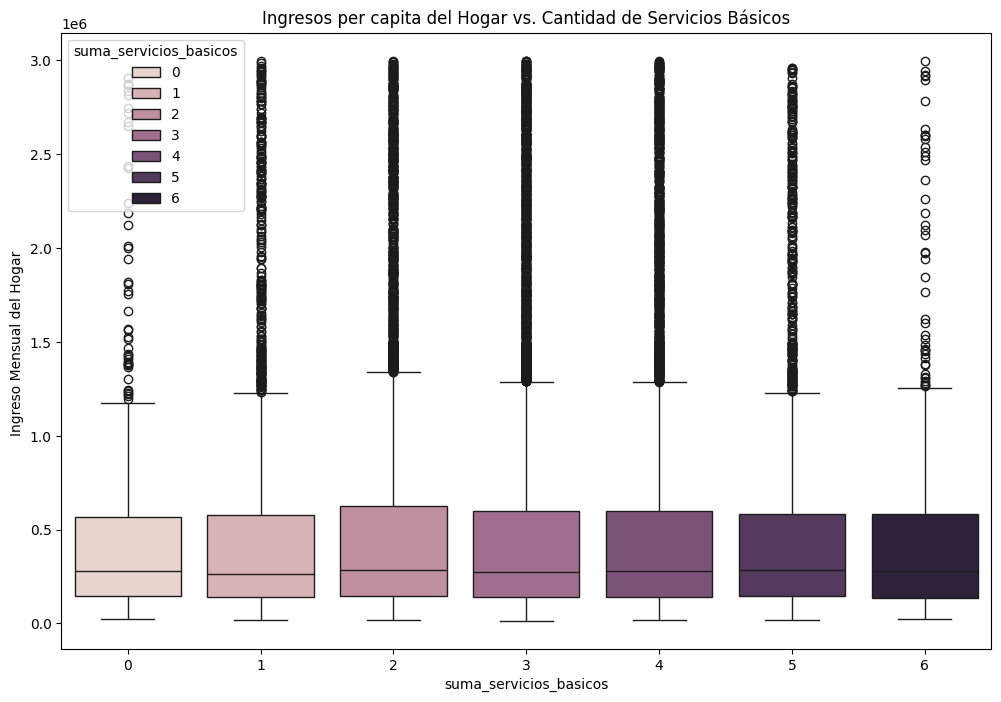

In [40]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_indicadores, x='suma_servicios_basicos', y='ingreso_per_capita', hue='suma_servicios_basicos')
plt.title('Ingresos per capita del Hogar vs. Cantidad de Servicios Básicos')
plt.ylabel('Ingreso Mensual del Hogar ')

plt.show()

In [41]:
df_indicadores[df_indicadores['suma_servicios_basicos'] == 6]

,id_vivienda,comuna,tipo_vivienda,num_dormitorios,num_banos,superficie_m2,ano_construccion,material_paredes,material_techo,num_personas_hogar,...,media_agua_losa_flag,losa_adobe_flag,score_inconsistencias,personas_por_dormitorio,indice_masculinidad,porc_menores_18,porc_adultos_18_64,porc_adultos_65_plus,ingreso_per_capita,suma_servicios_basicos
176,VIV_000176,Talcahuano,Media agua,1,2,157.6,1982,Ladrillo,Zinc,1,...,False,False,0.000000,1.0,0.000000,0.000000,0.000000,100.000000,4.486190e+05,6
206,VIV_000206,Chillán,Casa,4,3,36.3,2005,Madera,Paja,2,...,False,False,0.000000,0.5,NaN,0.000000,100.000000,0.000000,3.030790e+05,6
265,VIV_000265,San antonio,Departamento,3,3,110.7,2002,Adobe,Losa,9,...,False,True,14.285714,3.0,200.000000,33.333333,0.000000,66.666667,2.850151e+05,6
291,VIV_000291,Copiapó,Departamento,1,2,182.2,1974,Madera,Tejas,2,...,False,False,14.285714,2.0,0.000000,0.000000,0.000000,100.000000,1.065077e+06,6
315,VIV_000315,Maipú,Media agua,1,3,126.3,1992,Hormigón,Paja,3,...,False,False,28.571429,3.0,NaN,66.666667,0.000000,33.333333,7.027380e+05,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31355,VIV_031355,Temuco,Media agua,1,3,148.6,1972,Adobe,Losa,2,...,True,True,28.571429,2.0,100.000000,0.000000,50.000000,50.000000,1.708150e+05,6
31441,VIV_031441,Alto hospicio,Media agua,5,1,76.4,2011,Madera,Tejas,19,...,False,False,0.000000,3.8,5.555556,15.789474,52.631579,31.578947,1.034640e+05,6
31461,VIV_031461,Quilpué,Casa pareada,1,3,30.4,1982,Madera,Zinc,2,...,False,False,0.000000,2.0,100.000000,50.000000,50.000000,0.000000,1.226366e+06,6
31462,VIV_031462,Iquique,Casa,1,3,189.5,1970,Adobe,Tejas,3,...,False,False,0.000000,3.0,200.000000,0.000000,100.000000,0.000000,8.543023e+05,6


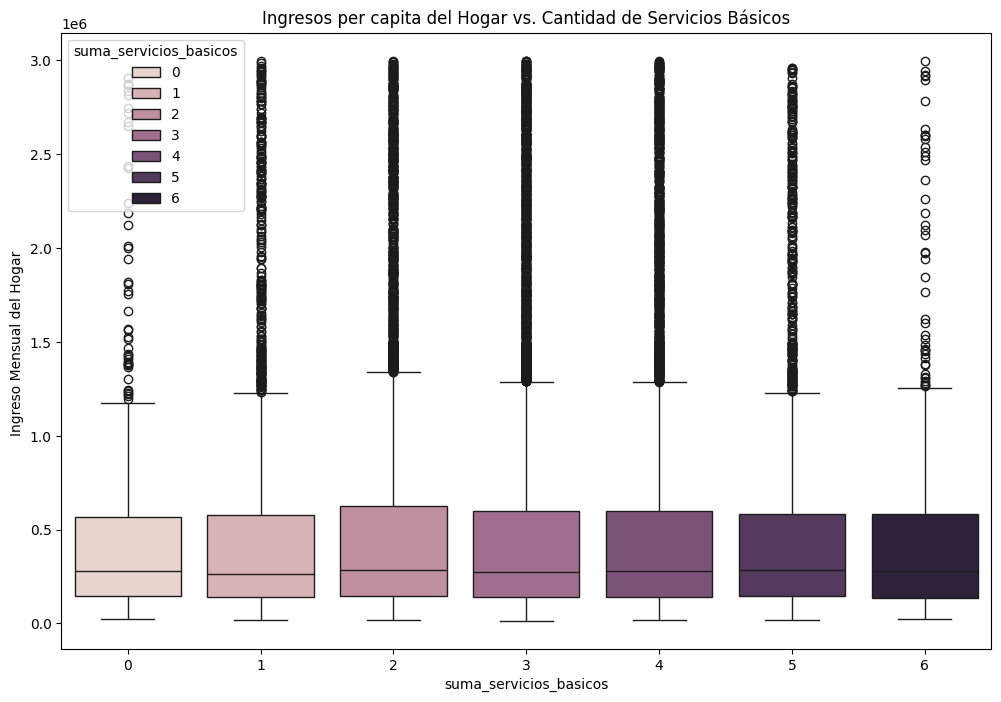

In [42]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_indicadores, x='suma_servicios_basicos', y='ingreso_per_capita', hue='suma_servicios_basicos')
plt.title('Ingresos per capita del Hogar vs. Cantidad de Servicios Básicos')
plt.ylabel('Ingreso Mensual del Hogar ')

plt.show()


0   id_vivienda            31660 non-null  object 
 1   comuna                 31660 non-null  object 
 2   tipo_vivienda          31660 non-null  object 
 3   num_dormitorios        31660 non-null  int64  
 4   num_banos              31660 non-null  int64  
 5   superficie_m2          31660 non-null  float64
 6   ano_construccion       31660 non-null  int64  
 7   material_paredes       31660 non-null  object 
 8   material_techo         31660 non-null  object 
 9   num_personas_hogar     31660 non-null  int64  
 10  num_hombres            31660 non-null  int64  
 11  num_mujeres            31660 non-null  int64  
 12  num_menores_18         31660 non-null  int64  
 13  num_adultos_18_64      31660 non-null  int64  
 14  num_adultos_65_plus    31660 non-null  int64  
 15  ingreso_mensual_hogar  31660 non-null  int64  
 16  jefe_hogar_edad        31660 non-null  int64  
 17  jefe_hogar_sexo        31660 non-null  object 
 18  jefe_hogar_educacion   31660 non-null  object 
 19  agua_potable           31660 non-null  object 
 20  electricidad           31660 non-null  object 
 21  gas_natural            31660 non-null  object 
 22  internet               31660 non-null  object 
 23  telefono_fijo          31660 non-null  object 
 24  vehiculo_propio        31660 non-null  object 
 25  tenencia_vivienda      31660 non-null  object 
dtypes: float64(1), int64(11), object(14)
memory usage: 6.3+ MB

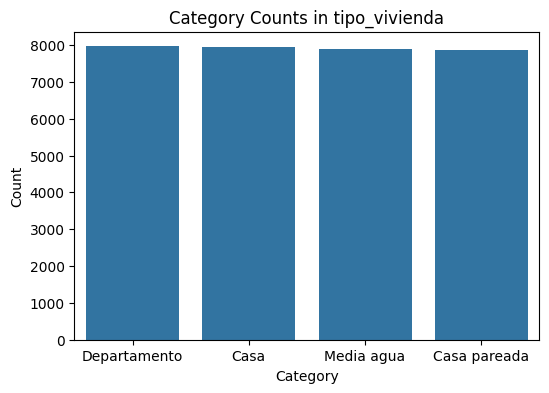

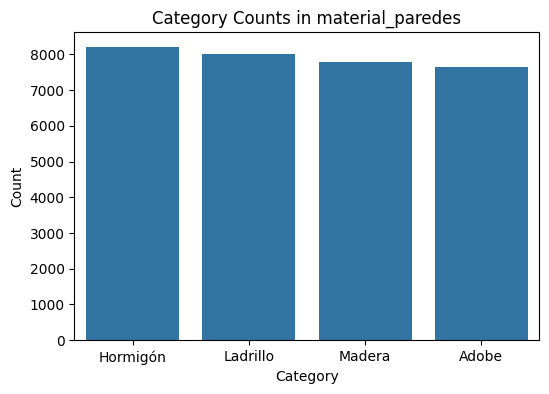

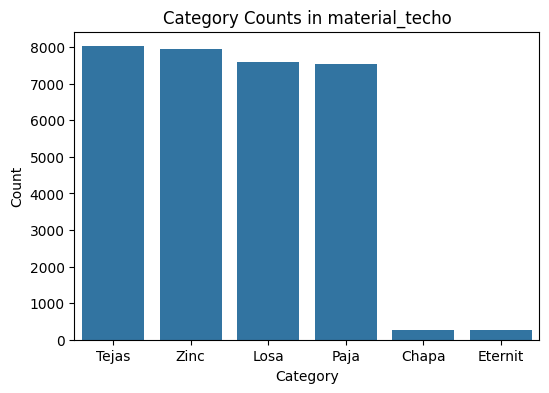

In [43]:
# Identificación de outliers en características de vivienda


for col in ["tipo_vivienda", "material_paredes", "material_techo"]:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df_indicadores, order=df_indicadores[col].value_counts().index)
    plt.title(f'Category Counts in {col}')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()


In [44]:
# tamaño de las viviendas segun su año de construccion
df_indicadores

,id_vivienda,comuna,tipo_vivienda,num_dormitorios,num_banos,superficie_m2,ano_construccion,material_paredes,material_techo,num_personas_hogar,...,media_agua_losa_flag,losa_adobe_flag,score_inconsistencias,personas_por_dormitorio,indice_masculinidad,porc_menores_18,porc_adultos_18_64,porc_adultos_65_plus,ingreso_per_capita,suma_servicios_basicos
0,VIV_000000,Vallenar,Casa,4,3,48.8,2012,Ladrillo,Losa,1,...,False,False,0.0,0.250000,0.0,0.000000,100.000000,0.000000,2.474753e+06,4
1,VIV_000001,Coyhaique,Casa pareada,2,1,152.6,1982,Madera,Tejas,7,...,False,False,0.0,3.500000,75.0,42.857143,42.857143,14.285714,3.398209e+05,3
2,VIV_000002,La serena,Casa,1,3,73.6,2012,Adobe,Paja,3,...,False,False,0.0,3.000000,NaN,0.000000,0.000000,100.000000,3.295090e+05,5
3,VIV_000003,Curicó,Casa,3,3,69.4,2002,Ladrillo,Losa,2,...,False,False,0.0,0.666667,NaN,50.000000,0.000000,50.000000,7.006550e+05,1
4,VIV_000004,Los ángeles,Casa pareada,1,1,62.6,2004,Adobe,Zinc,3,...,False,False,0.0,3.000000,200.0,66.666667,0.000000,33.333333,9.726930e+05,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31647,VIV_031647,Villa alemana,Casa,1,3,190.5,1999,Adobe,Paja,3,...,False,False,0.0,3.000000,50.0,0.000000,33.333333,66.666667,2.127763e+05,2
31648,VIV_031648,Maipú,Casa,5,1,114.6,1953,Madera,Paja,17,...,False,False,0.0,3.400000,70.0,5.882353,23.529412,70.588235,1.155523e+05,4
31649,VIV_031649,San antonio,Departamento,4,2,30.3,2005,Ladrillo,Zinc,2,...,False,False,0.0,0.500000,0.0,50.000000,50.000000,0.000000,1.064441e+06,4
31650,VIV_031650,Ñuñoa,Casa pareada,1,1,198.7,2020,Ladrillo,Zinc,2,...,False,False,0.0,2.000000,NaN,50.000000,50.000000,0.000000,4.178150e+05,5


In [45]:
df_indicadores.to_csv(INTERIM_DATA_DIR / "indicadores_vivienda_interim.csv")